# Vehicle Detection Project

### Proposed Pipeline
- Process images for HOG
- Process images for color / spatial histograms
- Train an SVM classifier to identify cars using HOG, colour and spatial features as well
- Refine the classifer using grid search to find the best permutation of parameters
- Develop sliding window to run over image and test regions against the classifier
- Update HOG function to perform sub-sampling of single HOG image during sliding window on each frame
- Use detections to generate a heat map over the image
- Draw bounding boxes based on high energy regions in the heat map
- Create a heat map class and update it over subsequent frames, applying average or decay to heat from last n frames
- Apply pipeline to video

### Imports

In [1]:
import glob
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import numpy as np
from moviepy.editor import VideoFileClip
from skimage.feature import hog
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

### Helper Functions from Project One

In [2]:
def calculate_mask_colors_hls():
    """Calculate colors in HLS used for defining a color mask
    """
    # Show the three components of the color yellow in the HLS color space
    # To turn this color into a range for masking, +/- 10 to the Hue value
    # for the Hue range and set a range 100-255 for the Lightness and 
    # Saturation values
    yellow = np.uint8([[[255,255,0 ]]])
    hls_yellow = cv2.cvtColor(yellow,cv2.COLOR_RGB2HLS)
    print (hls_yellow)

    # Show the three components of the color white in the HLS color space
    # The normal approach to turn a color into a range doesn't work here since
    # white isn't really a color. Looking at an HLS color cylinder we can see
    # that the Hue and Saturation don't really matter as any high Light value 
    # is essentially white. We can see this with the result of the code below
    # [0, 255, 0] (No Hue, 100% Light, No Saturation). To turn this into a range
    # use 0-255 for the Hue, 200-255 for the Light and 0-255 for the Saturation,
    # increasing the lower Light value to increase the sensitivity
    white = np.uint8([[[255,255,255 ]]])
    hls_white = cv2.cvtColor(white,cv2.COLOR_RGB2HLS)
    print (hls_white)

def mask_colors_hls(img):
    """Given an image in HLS space, mask the white and yellow color ranges for 
    lane isolation
    """
    
    # See calculate_mask_colors_hls() above for deriving ranges in HLS color space
    # white mask
    lower = np.uint8([0, 200, 0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(img, lower, upper)
    
    # yellow mask
    lower = np.uint8([ 15, 100, 100])
    upper = np.uint8([ 45, 255, 255])
    yellow_mask = cv2.inRange(img, lower, upper)
    
    # combined mask
    combined = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(img, img, mask = combined)

def process_image_plot(item, ax, mplot):
    """plot an image using the given axis and plot reference
    
    Args:
        item -- item holding image data to be ploted
        ax -- axis reference that can be used to modify the plot
        mplot -- reference to matplotlib that can be used to plot the image
    """    
    ax.set_xticks([]) # remove horizontal ticks from image
    ax.set_yticks([]) # remove vertical ticks from image
    mplot.imshow(item[0], cmap=item[1]) # display image with specified cmap
    if (len(item) == 3):
        ax.set_title(item[2])

def tile_images(images, col_num):
    """Plot multiple images in a single image
    
    Args:
        images -- array of images to plot
        col_num -- number of required columns in the plot
    """
    # determine image size to calculate desired figure height
    shape = images[0][0].shape
    img_height = float(shape[0])
    img_width = float(shape[1])
    tile_plots(images, col_num, img_width, img_height, process_image_plot)

def tile_plots(items, col_num, item_width, item_height, processor):
    """Plot multiple items in a single image, each item is processed using the 
    given processor function. The processor function takes as arguments 
    an item, axis and plot reference. It's up to the processor to define how to
    use the axis and plot object to plot the item.
    
    Args:
        items -- array of objects to be processed and ploted in each cell of the figure
        col_num -- number of required columns in the plot
        item_width -- original width of the item, used to retain aspect ratio
        item_height -- original width of the item, used to retain aspect ratio
        processor -- function which takes an item, axis and plot reference and uses
            the axis and plot reference to plot the item
    """
    if len(items) == 0:
        return
    notebook_pixel_width = 900.0
    col_width = notebook_pixel_width / float(col_num)
    row_height = (col_width / item_width) * item_height
    # divide images by required columns to determine number of rows
    row_num = math.ceil(len(items)/col_num)
    fig = plt.figure()
    # figure size is specified in inches, so divide required pixel size by dots per inch
    dpi = fig.get_dpi()
    fig.set_size_inches(notebook_pixel_width/float(dpi), (row_num*row_height)/float(dpi))
    # create a grid layout to position the individual plots
    gridspec.GridSpec(row_num ,col_num)
    for i, item in enumerate(items):
        row = i // col_num # integer floor divide to increment row after all columns
        col = i % col_num # increment col from 0 to cols-1 and cycle back to 0
        ax = plt.subplot2grid((row_num, col_num), (row, col)) # create plot in correct grid cell
        processor(item, ax, plt)
        plt.tight_layout() # remove margins from figure
        
    plt.show()
    
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

### Load Data

In [3]:
v_images = glob.glob('training_data/vehicles/**/*.png')
nonv_images = glob.glob('training_data/non-vehicles/**/*.png')
print(len(v_images), len(nonv_images))

8792 8968


### Display Data

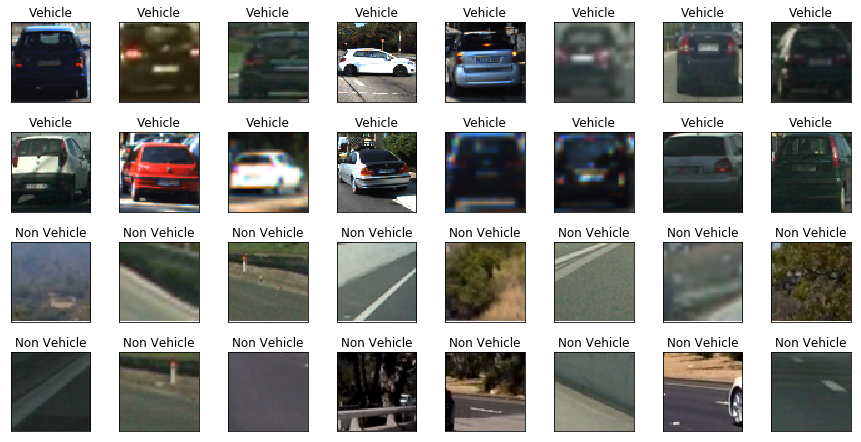

In [4]:
disp_images = []
for i in range(16):
    img = cv2.imread(v_images[np.random.randint(0,len(v_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    disp_images.append((img, None, "Vehicle"))
for i in range(16):
    img = cv2.imread(nonv_images[np.random.randint(0,len(nonv_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    disp_images.append((img, None, "Non Vehicle"))
    
tile_images(disp_images, 8)

### Create HOG

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

### Preprocess Image

In [6]:
def equalize_brightness(img):
    # normalize the histogram to remove the effect of brightness
    img[:,:,0] = cv2.equalizeHist(img[:,:,0])
    img[:,:,1] = cv2.equalizeHist(img[:,:,1])
    img[:,:,2] = cv2.equalizeHist(img[:,:,2])
    return img

def preprocess_image(img):
    img = equalize_brightness(img)
    return img
    

### Display Preprocessed Images

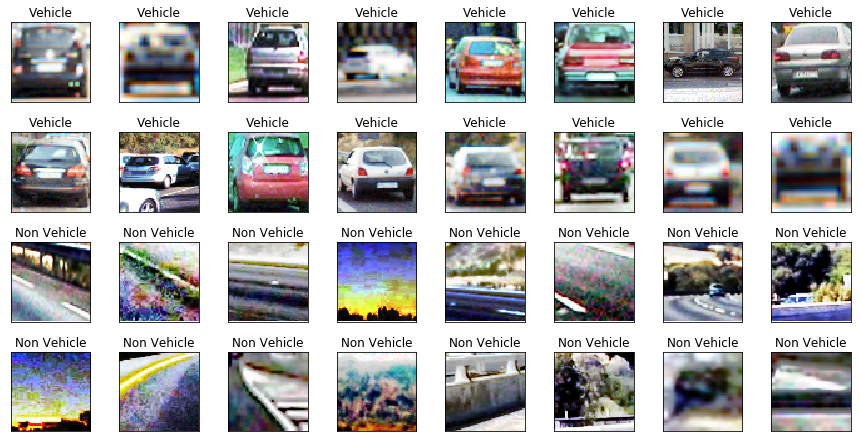

In [7]:
disp_images = []
for i in range(16):
    img = cv2.imread(v_images[np.random.randint(0,len(v_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = preprocess_image(img)
    disp_images.append((img, None, "Vehicle"))
for i in range(16):
    img = cv2.imread(nonv_images[np.random.randint(0,len(nonv_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = preprocess_image(img)
    disp_images.append((img, None, "Non Vehicle"))
    
tile_images(disp_images, 8)

### Display HOG

In [34]:
def convert_color(img, conv='RGB2YCrCb'):
    if color_space == 'RGB':
        return np.copy(img)
    if color_space == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if color_space == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if color_space == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if color_space == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if color_space == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if color_space == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if color_space == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if color_space == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

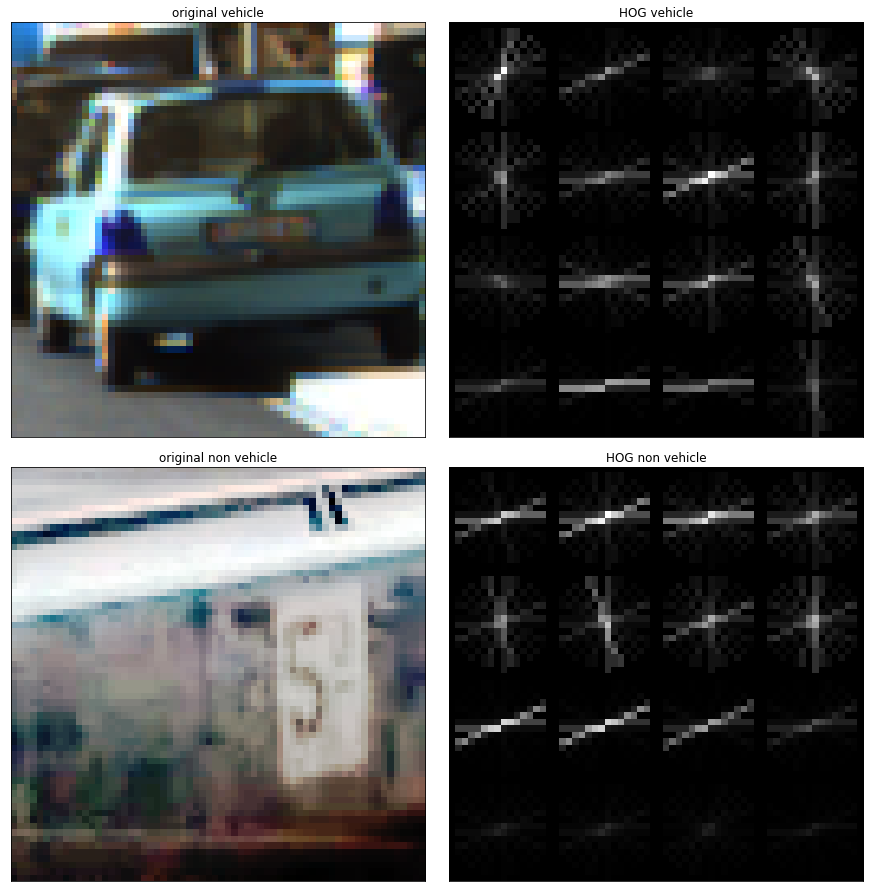

In [35]:
# Define HOG parameters
color_space = 'RGB2YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb, RGB2YCrCb, BGR2YCrCb
orient = 15  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block

v = cv2.imread(v_images[np.random.randint(0,len(v_images))])
# v = preprocess_image(v)
yuv_v = convert_color(v, color_space)
yuv_v = yuv_v[:,:,0]

nonv = cv2.imread(nonv_images[np.random.randint(0,len(nonv_images))])
nonv = preprocess_image(nonv)
yuv_nonv = convert_color(nonv, color_space)
yuv_nonv = yuv_nonv[:,:,0]

# Call our function with vis=True to see an image output
_, hog_v_image = get_hog_features(gray_v, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

_, hog_nonv_image = get_hog_features(gray_nonv, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

tile_images([
    (v, None, "original vehicle"),
    (hog_v_image, "gray", "HOG vehicle"),
    (nonv, None, "original non vehicle"),
    (hog_nonv_image, "gray", "HOG non vehicle")], 2)

### Extract Features

In [9]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = convert_color(img, color_space)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        img_features = single_img_features(image, color_space, spatial_size,
                        hist_bins, orient, pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat)
        
        features.append(img_features)
    # Return list of feature vectors
    return features

### Collect Features for all Training Data

In [10]:
# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
# sample_size = 500
# cars = v_images[0:sample_size]
# notcars = nonv_images[0:sample_size]

cars = v_images
notcars = nonv_images

hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 64    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

57.23 Seconds to extract features...


### Train Classifier

In [11]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 15 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 2580
4.28 Seconds to train SVC...
Test Accuracy of SVC =  0.989301801802
My SVC predicts:  [ 1.  1.  0.  1.  0.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  1.  1.  1.  0.  0.]
0.00128 Seconds to predict 10 labels with SVC


### Algorithm to Determine Sliding Windows

In [12]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

### Search Windows for Cars

In [13]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    img = img.astype(np.float32)/255
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = X_scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

### Draw Boxes on the Image

In [14]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        clr = color
        if color == 'r':
            clr = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
        cv2.rectangle(imcopy, bbox[0], bbox[1], clr, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Find Cars in Single Image with Simple Sliding Window

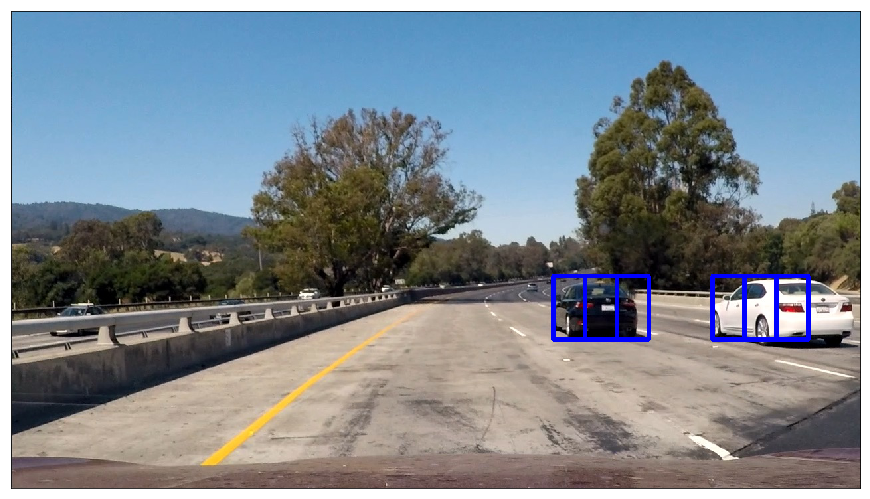

In [15]:
image = mpimg.imread('./test_images/test1.jpg')
draw_image = np.copy(image)
y_start_stop = [400, 656] # Min and max in y to search in slide_window()

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

tile_images([(window_img, None)], 1)

### Improve Search Windows to Sub-Sample HOG Image

In [16]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, all_rectangles=False):
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=cspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 3
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 3 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    rectangles = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if all_rectangles or test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
                
    return rectangles
    

### Find Cars Using HOG Sub -Sampling

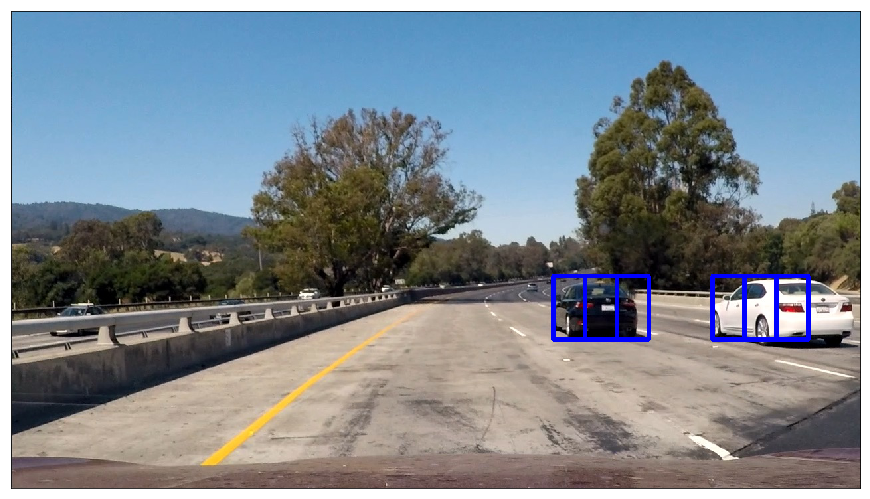

In [17]:
ystart = 400
ystop = 656
scale = 1.5

img = mpimg.imread('./test_images/test1.jpg')
draw_image = np.copy(img)

hot_windows = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                        cell_per_block, spatial_size, hist_bins, color_space)
draw_image = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)   

tile_images([(draw_image, None)], 1)

### Improve Sliding Window for Vehicles at Various Depths

In [18]:
def get_multi_depth_windows(img, multi_depth, pix_per_cell, cell_per_block, all_rectangles=False):
    windows = []
    for params in multi_depth:
        rectangles = find_cars(img, params[1], params[2], params[0], svc, X_scaler, orient, pix_per_cell, 
                               cell_per_block, spatial_size, hist_bins, color_space, all_rectangles)
        for rect in rectangles:
            windows.append(rect)
            
    return windows

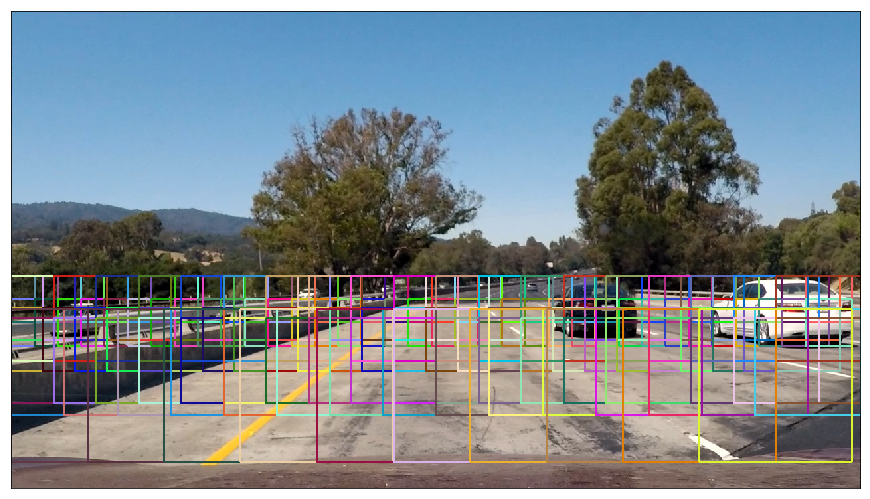

In [19]:
multi_depth = [
    [1.1, 400, 540],
    [1.5, 400, 560],
    [2, 400, 620], 
    [2.5, 450, 640],
    [3.6, 450, 720]
] 

image = mpimg.imread('./test_images/test1.jpg')
draw_image = np.copy(image)
windows = get_multi_depth_windows(image, multi_depth, pix_per_cell, cell_per_block, all_rectangles=True)
draw_image = draw_boxes(draw_image, windows, color='r', thick=2)

tile_images([(draw_image, None)], 1)

### Detect Vehicles with Improved Sliding Window

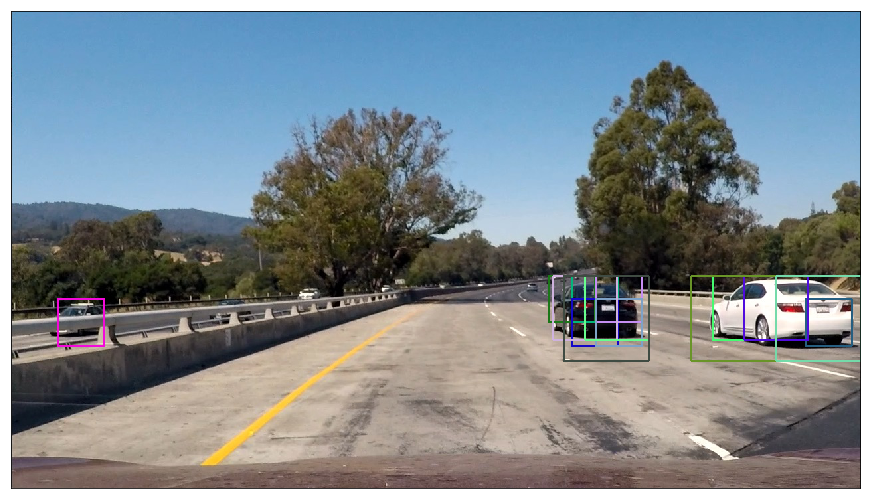

In [20]:
image = mpimg.imread('./test_images/test1.jpg')
draw_image = np.copy(image)
hot_windows = get_multi_depth_windows(image, multi_depth, pix_per_cell, cell_per_block, all_rectangles=False)
draw_image = draw_boxes(draw_image, hot_windows, color='r', thick=2)

tile_images([(draw_image, None)], 1)

### Generate Heat Map for Vehicle Detection

In [21]:
# Generate a heat map to help identify false positives

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

### Display Heat Map for Test Image

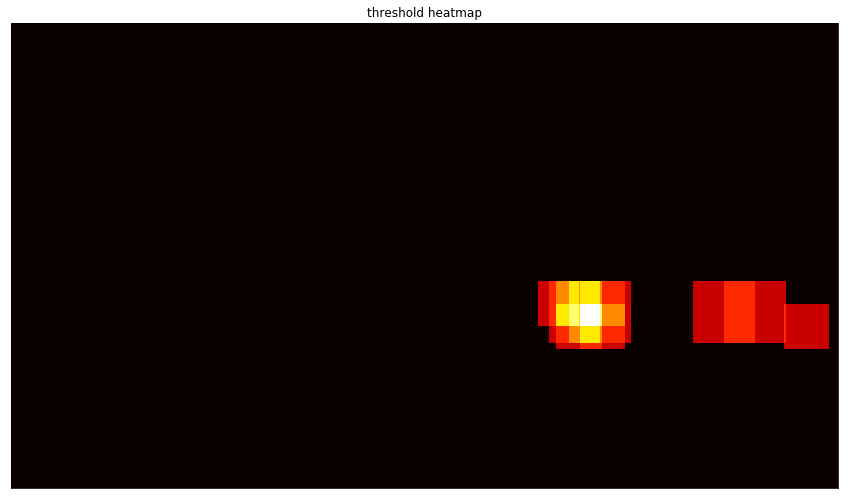

In [22]:
image = mpimg.imread('./test_images/test1.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)
heat = add_heat(heat, hot_windows)
threshold = apply_threshold(heat, 1.0)

tile_images([(threshold, 'hot', 'threshold heatmap')], 1)

### Draw Bounding Boxes for Heat Map

In [23]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

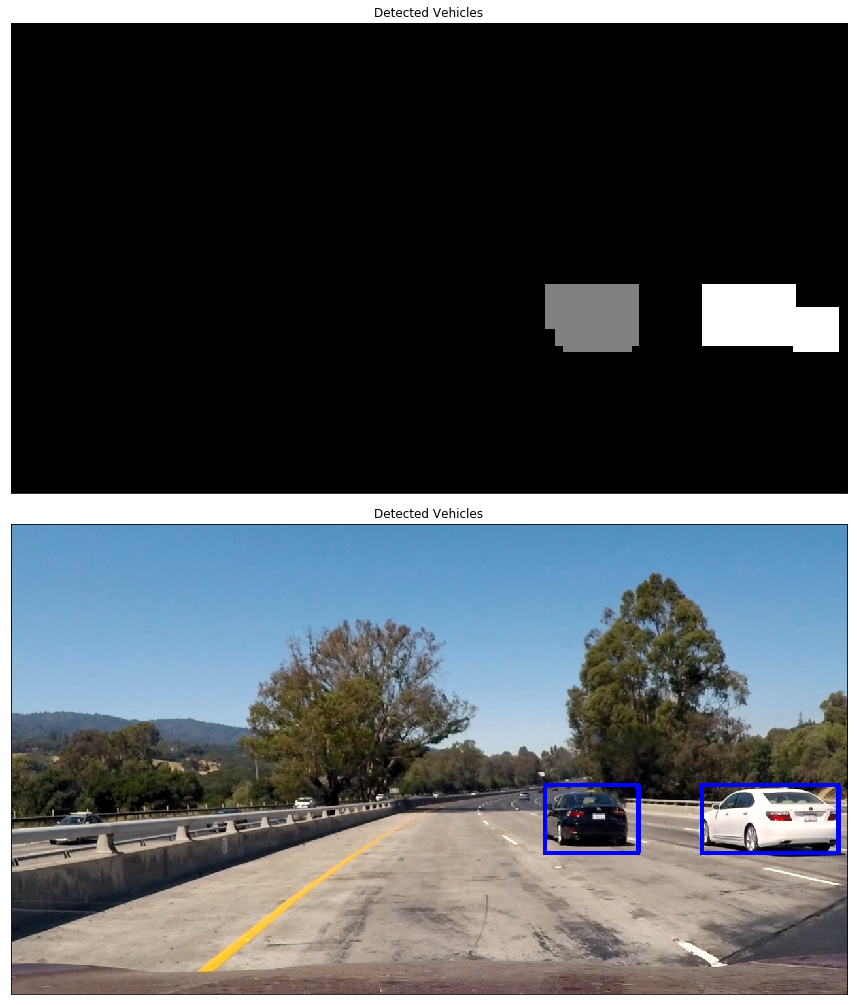

In [24]:
labels = label(threshold)
label_img = draw_labeled_bboxes(np.copy(image), labels)
tile_images([(labels[0], 'gray', 'Detected Vehicles'),(label_img, None, 'Detected Vehicles')], 1)

### Apply Pipeline to All Test Images

In [25]:
# Define a class to receive the characteristics of each line detection
class HeatMap():
    def __init__(self, n, factor):
        self.n = n
        self.frame_rectangles = []
        self.threshold_map = None
        self.threshold_factor = factor
        
    def add_heat(self, image, hot_windows):
        # add a new array entry holding the windows with detected cars from the supplied image / frame
        self.frame_rectangles.append(hot_windows)
        # remove oldest rectangle set
        self.frame_rectangles = self.frame_rectangles[-self.n:]
        # sum up all the n rectangle sets as a heatmap
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        for frame_rect in self.frame_rectangles:
            heat = add_heat(heat, frame_rect)
        # set the thresholded heatmap using a threshold of threshold_factor times the number of frames considered
        self.threshold_map = apply_threshold(heat, self.n*self.threshold_factor)

In [26]:
def process_image(image, heatmap):
    hot_windows = get_multi_depth_windows(image, multi_depth, pix_per_cell, cell_per_block, all_rectangles=False)
    heatmap.add_heat(image, hot_windows)
    labels = label(heatmap.threshold_map)
    return draw_labeled_bboxes(np.copy(image), labels)

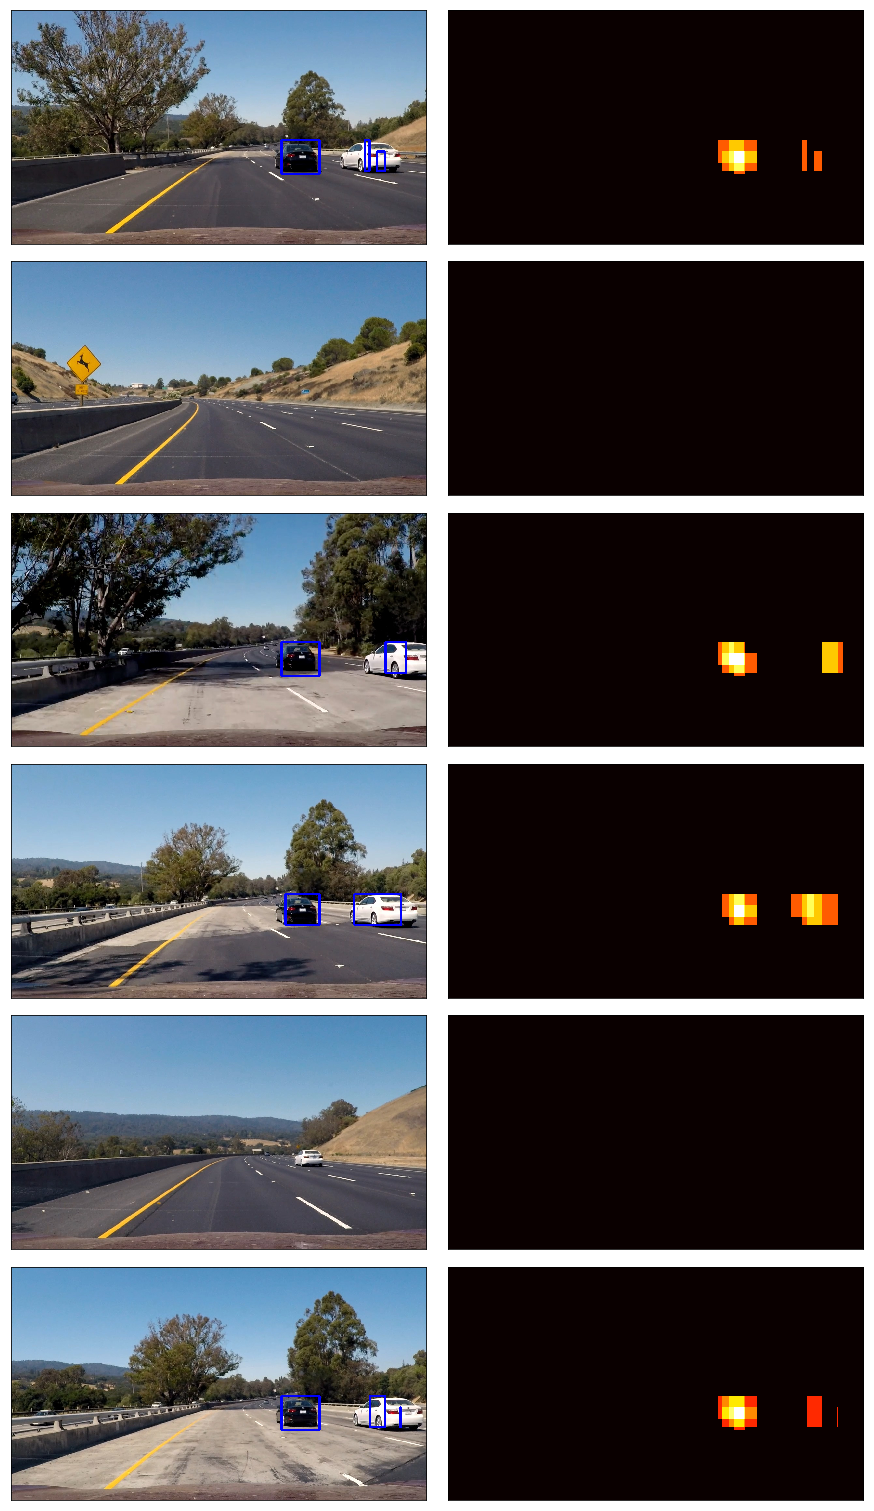

In [31]:
test_images = glob.glob('test_images/*.jpg')
heatmap = HeatMap(1, 2)
out_images = []
for image_path in test_images:
    t_image = mpimg.imread(image_path)
    out_img = process_image(t_image, heatmap)
    out_images.append((out_img, None))
    out_images.append((heatmap.threshold_map, 'hot'))
    
tile_images(out_images,2)

### Apply Pipeline to Video

In [28]:
# Using some scope trickery to pass an extra few parameters to the frame processor
def process_image_wrapper(clip, heatmap):
    def process_image_stateful(image):
        return process_image(image, heatmap)
    
    return clip.fl_image(process_image_stateful)

In [33]:
# heatmap accumulation over 30 frames
heatmap = HeatMap(30, 0.75)

video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
# video_input1 = VideoFileClip('test_video.mp4')
processed_video = video_input1.fx(process_image_wrapper, heatmap)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [06:47<00:00,  3.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 18min 56s, sys: 3.05 s, total: 18min 59s
Wall time: 6min 47s
